In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from feature_engine.outliers import Winsorizer


In [2]:
# Fijamos el directorio de trabajo
DIRECTORY =  "/home/spperez/masiv_model/"

In [3]:
# Datos
df = pd.read_csv(DIRECTORY + "data/interim/clean_data.csv")
df["InvoiceDate"] = df["InvoiceDate"].apply(lambda x: x.split(' ')[0])
df["InvoiceDate"] = df["InvoiceDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderValue,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010-12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  int64         
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   OrderValue   397884 non-null  float64       
 9   Month        397884 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 30.4+ MB


El enfoque que se va a tomar es el RFM clásico junto con una variable llamada mediana de la recompra
1.	Recency: número de días entre la fecha máxima de los datos y la fecha de la última compra de cada cliente.
2.	Frequency: número de transacciones distintas para cada cliente
3.	Monetary Value: es la suma del valor de compra para cada cliente
4.	MedianRepurchase: es la mediana de los días que transcurren entre cada compra de cada cliente

Se decide calcular la variable MedianRepurchase  ya que se tiene conocimientos para decir que es un mejor indicador de fidelidad que la misma Frequeancy. Se procede con el cálculo de estas variables.


In [5]:
df_r = df.groupby(['CustomerID'], as_index=False)['InvoiceDate'].max()
df_r.rename(columns={"InvoiceDate": "LastInvoiceDate"}, inplace=True)
df_r

,CustomerID,LastInvoiceDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02
...,...,...
4333,18280.0,2011-03-07
4334,18281.0,2011-06-12
4335,18282.0,2011-12-02
4336,18283.0,2011-12-06


In [6]:
current_date = df_r["LastInvoiceDate"].max()
df_r["Recency"] = (current_date - df_r["LastInvoiceDate"])/np.timedelta64(1, 'D')
df_r.drop(columns=["LastInvoiceDate"], inplace=True)
df_r

,CustomerID,Recency
0,12346.0,325.0
1,12347.0,2.0
2,12348.0,75.0
3,12349.0,18.0
4,12350.0,310.0
...,...,...
4333,18280.0,277.0
4334,18281.0,180.0
4335,18282.0,7.0
4336,18283.0,3.0


In [7]:
# Se crean las variables Frecuencia y Monto
df_fm = df.groupby('CustomerID').agg({
    'InvoiceNo'   : lambda x:x.nunique(),
    'OrderValue'  : lambda x:x.sum(),
    })

df_fm.rename(columns = {
    'InvoiceNo' :'Frequency',
    'OrderValue':'MonetaryValue'
    }, inplace= True) 

df_fm

,Frequency,MonetaryValue
CustomerID,,
12346.0,1,77183.60
12347.0,7,4310.00
12348.0,4,1797.24
12349.0,1,1757.55
12350.0,1,334.40
...,...,...
18280.0,1,180.60
18281.0,1,80.82
18282.0,2,178.05


In [8]:
df_rfm = df_r.merge(df_fm, left_on="CustomerID", right_on="CustomerID")
df_rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325.0,1,77183.60
1,12347.0,2.0,7,4310.00
2,12348.0,75.0,4,1797.24
3,12349.0,18.0,1,1757.55
4,12350.0,310.0,1,334.40
...,...,...,...,...
4333,18280.0,277.0,1,180.60
4334,18281.0,180.0,1,80.82
4335,18282.0,7.0,2,178.05
4336,18283.0,3.0,16,2094.88


In [9]:
df_rfm.describe()

,CustomerID,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.059474,4.272015,2054.266460
std,1721.808492,100.012264,7.697998,8989.230441
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,17.000000,1.000000,307.415000
50%,15299.500000,50.000000,2.000000,674.485000
75%,16778.750000,141.750000,5.000000,1661.740000
max,18287.000000,373.000000,209.000000,280206.020000


In [10]:
# Se crea la varible recompra
df_re = df[["CustomerID", "InvoiceDate"]].drop_duplicates()
df_re.sort_values(by=["CustomerID", "InvoiceDate"], ascending=True, inplace=True)
df_re["Index"] = df_re.groupby(["CustomerID"])["InvoiceDate"].rank()
df_re["PreviousPurchaseDay"] = df_re.groupby(["CustomerID"])["InvoiceDate"].shift(1)
df_re = df_re[df_re["Index"] > 1]
df_re["Repurchase"] = (df_re["InvoiceDate"]-df_re["PreviousPurchaseDay"])/np.timedelta64(1, 'D')
df_re.reset_index(inplace=True, drop=True)
df_re

,CustomerID,InvoiceDate,Index,PreviousPurchaseDay,Repurchase
0,12347.0,2011-01-26,2.0,2010-12-07,50.0
1,12347.0,2011-04-07,3.0,2011-01-26,71.0
2,12347.0,2011-06-09,4.0,2011-04-07,63.0
3,12347.0,2011-08-02,5.0,2011-06-09,54.0
4,12347.0,2011-10-31,6.0,2011-08-02,90.0
...,...,...,...,...,...
12420,18283.0,2011-11-23,12.0,2011-11-10,13.0
12421,18283.0,2011-11-30,13.0,2011-11-23,7.0
12422,18283.0,2011-12-06,14.0,2011-11-30,6.0
12423,18287.0,2011-10-12,2.0,2011-05-22,143.0


In [11]:
# Se saca la mediana de la recompra
median_repurchase =  df_re.groupby(["CustomerID"], as_index=False)["Repurchase"].median()
median_repurchase

,CustomerID,Repurchase
0,12347.0,58.5
1,12348.0,70.0
2,12352.0,14.5
3,12356.0,151.5
4,12358.0,149.0
...,...,...
2785,18272.0,43.0
2786,18273.0,127.5
2787,18282.0,119.0
2788,18283.0,21.0


In [12]:
df_rfm = df_rfm.merge(median_repurchase, how="left")
df_rfm.rename(columns={"Repurchase": "MedianRepurchase"}, inplace=True)
df_rfm.describe()

,CustomerID,Recency,Frequency,MonetaryValue,MedianRepurchase
count,4338.000000,4338.000000,4338.000000,4338.000000,2790.000000
mean,15300.408022,92.059474,4.272015,2054.266460,74.828674
std,1721.808492,100.012264,7.697998,8989.230441,68.123970
min,12346.000000,0.000000,1.000000,3.750000,1.000000
25%,13813.250000,17.000000,1.000000,307.415000,28.000000
50%,15299.500000,50.000000,2.000000,674.485000,52.500000
75%,16778.750000,141.750000,5.000000,1661.740000,97.000000
max,18287.000000,373.000000,209.000000,280206.020000,366.000000


In [13]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4338 entries, 0 to 4337
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        4338 non-null   float64
 1   Recency           4338 non-null   float64
 2   Frequency         4338 non-null   int64  
 3   MonetaryValue     4338 non-null   float64
 4   MedianRepurchase  2790 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 203.3 KB


Como se observa, el 35.7% de los valores de MedianRepurchase están vacíos, por lo tanto no vamos a considerar esta variable.

In [14]:
df_rfm.drop(columns=["MedianRepurchase"], inplace=True)

#### Distribuciones de las variables RFM

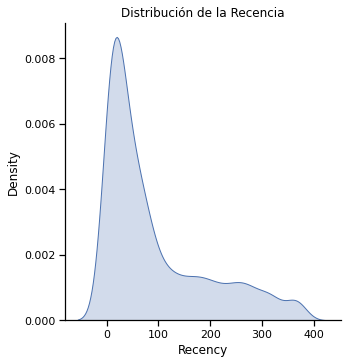

In [15]:
sns.set_theme(style=None)
g = sns.displot(df_rfm["Recency"], kind="kde", fill=True)
g.set(title="Distribución de la Recencia")

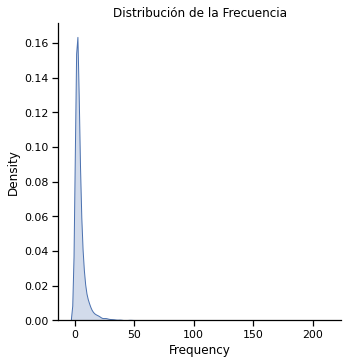

In [16]:
sns.set_theme(style=None)
g = sns.displot(df_rfm["Frequency"], kind="kde", fill=True)
g.set(title="Distribución de la Frecuencia")

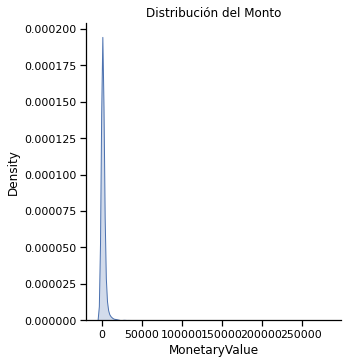

In [17]:
sns.set_theme(style=None)
g = sns.displot(df_rfm["MonetaryValue"], kind="kde", fill=True)
g.set(title="Distribución del Monto")

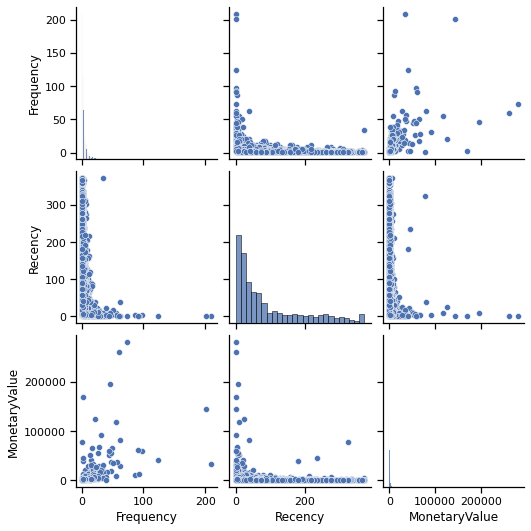

In [18]:
sns.set_theme(style=None)
sns.pairplot(df_rfm[["Frequency", "Recency", "MonetaryValue"]])


Las distribuciones de las tres variables se observan bastantes sesgadas, lo que sugiere un análisis de datos atípicos y una estandarización. 

In [19]:
df_rfm_std  = df_rfm.copy()
df_rfm_std

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325.0,1,77183.60
1,12347.0,2.0,7,4310.00
2,12348.0,75.0,4,1797.24
3,12349.0,18.0,1,1757.55
4,12350.0,310.0,1,334.40
...,...,...,...,...
4333,18280.0,277.0,1,180.60
4334,18281.0,180.0,1,80.82
4335,18282.0,7.0,2,178.05
4336,18283.0,3.0,16,2094.88


In [20]:
df_rfm_std[["FrequencyStd", "RecencyStd", "MonetaryValueStd"]]  = StandardScaler().fit_transform(df_rfm_std[["Frequency", "Recency", "MonetaryValue"]])
df_rfm_std

,CustomerID,Recency,Frequency,MonetaryValue,FrequencyStd,RecencyStd,MonetaryValueStd
0,12346.0,325.0,1,77183.60,-0.425097,2.329388,8.358668
1,12347.0,2.0,7,4310.00,0.354417,-0.900588,0.250966
2,12348.0,75.0,4,1797.24,-0.035340,-0.170593,-0.028596
3,12349.0,18.0,1,1757.55,-0.425097,-0.740589,-0.033012
4,12350.0,310.0,1,334.40,-0.425097,2.179389,-0.191347
...,...,...,...,...,...,...,...
4333,18280.0,277.0,1,180.60,-0.425097,1.849392,-0.208459
4334,18281.0,180.0,1,80.82,-0.425097,0.879399,-0.219560
4335,18282.0,7.0,2,178.05,-0.295178,-0.850588,-0.208742
4336,18283.0,3.0,16,2094.88,1.523687,-0.890588,0.004519


In [21]:
# Datos atípicos
capper = Winsorizer(capping_method="quantiles", tail="both", fold=0.05, variables=["FrequencyStd", "RecencyStd", "MonetaryValueStd"])
capper.fit(df_rfm_std)

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['FrequencyStd', 'RecencyStd', 'MonetaryValueStd'])

In [22]:
capper.right_tail_caps_

{'FrequencyStd': 1.133930095806538,
 'RecencyStd': 2.1893891394595237,
 'MonetaryValueStd': 0.4213946007963635}

In [23]:
# Se aplica a los datos 
df_rfm_std_wo = capper.transform(df_rfm_std)

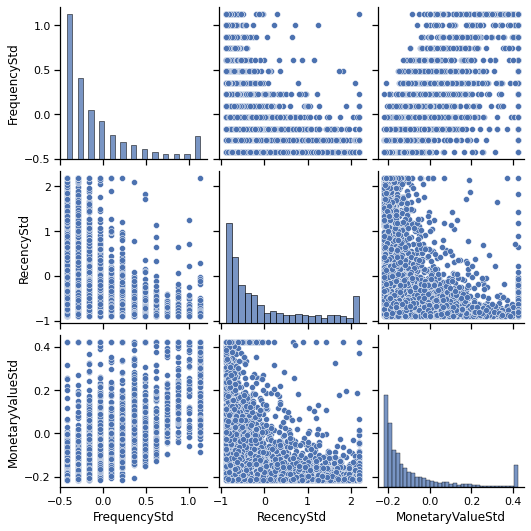

In [24]:
sns.set_theme(style=None)
sns.pairplot(df_rfm_std_wo[["FrequencyStd", "RecencyStd", "MonetaryValueStd"]])
plt.savefig(DIRECTORY + "reports/figures/distribucion.png")


Hacemos una proyección con UMAP para ver si los datos por si mismos tiene una tendencia en grupos.

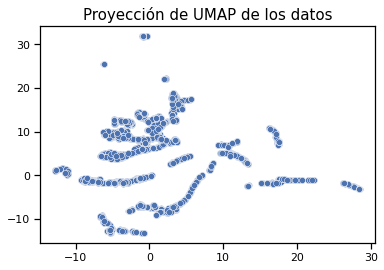

In [25]:
reducer = umap.UMAP(random_state=1234)
embedding = reducer.fit_transform(df_rfm_std_wo[["FrequencyStd", "RecencyStd", "MonetaryValueStd"]])
plt.title('Proyección de UMAP de los datos', fontsize=15)
sns.set_theme(style=None)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])
plt.savefig(DIRECTORY + "reports/figures/UMAP.png")


In [26]:
# Se guardan los datos RFM ya procesados.
df_rfm_std_wo.to_csv(DIRECTORY + "data/processed/rfm_standardized.csv", index=False)